In [1]:
from   IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.lotka import solveLotkaVolterra
from lib.utils import updatePLT, horizental_plot, simulate_ou_signal_price, parameter_study_plot, trading_simulation_plot
from lib.target import solve_g1_OU_closedform, solve_g1_OU_montecarlo, solve_FBSDE, get_strat_simulation

# ----------------------------------------
# - One strategy simulation with OU signal
# ----------------------------------------

In [4]:
# Time
T, nb_t    = 1, 1001

# cost & penalty parameters
k, c, phi, varphi       = 1e-3, 5e-3, 0.1, 0.1

# Signal (OU) parameters
r_signal, sigma_signal = 1, 5

# Fundamental price
sigma_price, F0        = 1, 100

# transient impact
sigma_transient, beta  = 0., 5

# Target strategy: TWAP 
Q0           = 100
q_target_T   = 50
q_target = np.linspace(Q0, q_target_T, nb_t)

In [5]:
# solve the ODE system
Gt, ts, g2, g3, g4 = solveLotkaVolterra(phi  = phi, beta = beta, c = c, T = T, nb_t = nb_t, k = k, varphi = varphi)

In [6]:
%%time

# random seed
np.random.seed(20)

# generate signal & fundamental price
alpha, F = simulate_ou_signal_price(r_signal    = r_signal,    sigma_signal = sigma_signal, 
                                    sigma_price = sigma_price, F0           = F0,          T = T, nb_t = nb_t)

# Solve g1
g1       = solve_g1_OU_closedform(q_target, g2, g3, k, c, phi, sigma_signal, r_signal, alpha, varphi, q_target_T, T, nb_t)

# Solve the FBSDE system
nu, Q, I, Y = solve_FBSDE(Q0, g1, g2, g3, g4, beta, c, k, sigma_transient, T, nb_t)

CPU times: user 9.47 s, sys: 37.5 ms, total: 9.51 s
Wall time: 9.52 s


### Some analysis

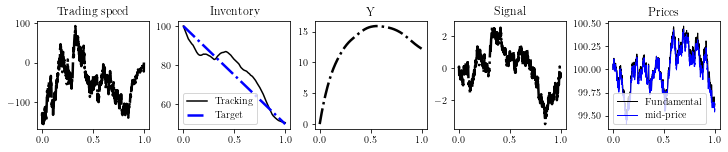

In [7]:
# plot the solution
axes = trading_simulation_plot(ts, nu, Q, q_target, I, Y, F, alpha)

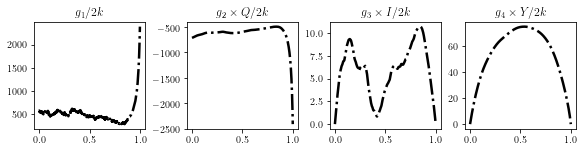

In [8]:
# Plot the constituents of the optimal trading speed
_ = horizental_plot(ts, (g1/2/k, g2*Q[:,0]/2/k, g3*I[:,0]/2/k, g4*Y[:,0]/2/k),
                        (r'$g_1 / 2k$', r'$g_2 \times Q / 2k$', r'$g_3 \times I / 2k$', r'$g_4 \times Y / 2k$'))

In [9]:
# compare g1 with MC estimators
# g1_mc = solve_g1_OU_montecarlo(q_target, g2, g3, k, c, phi, r_signal, sigma_signal, varphi, q_target_T, 10, T, nb_t)

# _ = horizental_plot(ts, (g1, g1_mc, g1 - g1_mc), 
#                    (r'$g_1$', r'$\hat{g}_1$', r'$\hat{g}_1 - g_1$'))

# ----------------------------------------
# - Study of dependence on parameters
# ----------------------------------------

In [10]:
from lib.utils import simulations_plot

In [11]:
T, nb_t      = 1, 1001

# Target strategy: TWAP 
Q0           = 100
q_target_T   = 20
q_target = np.linspace(Q0, q_target_T, nb_t)

## Effect of tracking penalty \phi

In [12]:
def get_strat_simulation(nb_t, r_signal, c, k, phi, sigma_signal, 
                       beta, sigma_transient, sigma_price, q_target, 
                       F0, Q0, T, varphi):
    
    # solve the ODE system
    Gt, ts, g2, g3, g4 = solveLotkaVolterra(phi  = phi, beta = beta, c = c, T = T, nb_t = nb_t, k = k, varphi = varphi)

    # generate signal & fundamental price
    alpha, F = simulate_ou_signal_price(r_signal = r_signal, sigma_signal = sigma_signal, 
                                        sigma_price = sigma_price, F0 = F0, T = T, nb_t = nb_t)

    # Solve g1
    g1       = solve_g1_OU_closedform(q_target, g2, g3, k, c, phi, sigma_signal, r_signal, alpha, varphi, q_target_T, T, nb_t)

    # Solve the FBSDE system
    nu, Q, I, Y = solve_FBSDE(Q0, g1, g2, g3, g4, beta, c, k, sigma_transient, T, nb_t)
    
    return ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4

In [13]:
np.random.seed(14)
Trajectories = {}
for n in range(20):
    if (n%5)==0: print(n)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t      = nb_t, 
                                                                       r_signal  =  1,     sigma_signal  =  5, 
                                                                       c         =  1e-3,  k             =  1e-3,  beta  =  5, 
                                                                       phi       =  0.5,
                                                                       sigma_price = 1, T = 1,
                                                                       sigma_transient = 0., 
                                                                       q_target  =  q_target, F0=100, Q0=100, varphi = 1e-1)
    Trajectories[n] = (Q, alpha)

0
5
10
15


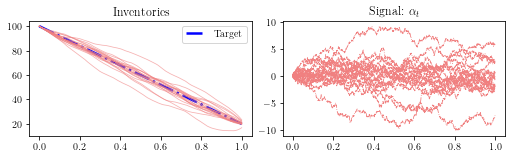

In [14]:
simulations_plot(ts, q_target, Trajectories, 'results/penalty_loose.pdf', W=7)

In [15]:
np.random.seed(14)
Trajectories = {}
for n in range(20):
    if (n%5)==0: print(n)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t   = nb_t, 
                                                                   r_signal  =  1,     sigma_signal  =  5, 
                                                                   c         =  1e-3,  k             =  1e-3,  beta  =  5, 
                                                                   phi       =  2,
                                                                   sigma_price = 1, T = 1, 
                                                                   sigma_transient = 0.5, 
                                                                   q_target  =  q_target, F0=100, Q0=100, varphi = 1e-1)
    Trajectories[n] = (Q, alpha)

0
5
10
15


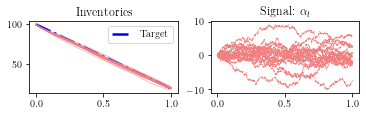

In [16]:
simulations_plot(ts, q_target, Trajectories, 'results/penalty_tight.pdf', W=5)

In [17]:
np.random.seed(14)
Trajectories = {}
for phi_ in (1e-1, 3e-1, 5e-1, 1):
    np.random.seed(10)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t      = nb_t, 
                                                                       r_signal  =  1,     sigma_signal  =  5, 
                                                                       c         =  1e-3,  k             =  1e-3,  beta  =  5, 
                                                                       phi       =  phi_,
                                                                       sigma_price = 1, T = 1, 
                                                                       sigma_transient = 0., 
                                                                       q_target  =  q_target, F0=100, Q0=100, varphi = 1e-1)
    Trajectories[phi_] = Q

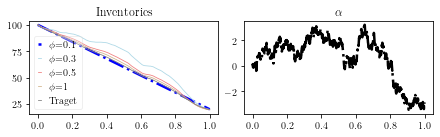

In [18]:
parameter_study_plot(ts, q_target, Trajectories, alpha, '$\phi$', savefigname='results/penalty_different_values.pdf',  W=6)

## Effect of signal strength

In [19]:
np.random.seed(14)
Trajectories = {}
for sigma_signal_ in (1, 2, 5, 10):
    np.random.seed(10)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t      = nb_t, 
                                                                      r_signal  =  10,     sigma_signal  =  sigma_signal_, 
                                                                      c         =  1e-3,  k  =  1e-3,  beta  =  1, 
                                                                      phi       =  0.05,
                                                                      sigma_price = 1, T = 1, 
                                                                      sigma_transient = 0., 
                                                                      q_target  =  q_target, F0=F0, Q0=Q0, varphi = 1e-1)
    Trajectories[sigma_signal_] = (Q, alpha)

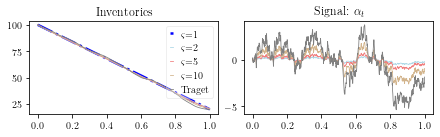

In [20]:
parameter_study_plot(ts, q_target, Trajectories, alpha, r'$\varsigma$', savefigname='results/signalstrength_different_values.pdf',  W=6)

## Effect of transient impact

In [21]:
np.random.seed(14)
Trajectories = {}
for c_ in (0, 1e-3, 5e-3, 1e-2):
    np.random.seed(10)
    print('c=',c_)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t      = nb_t, 
                                                                      r_signal  =  10,     sigma_signal     =  5, 
                                                                      c         =  c_,  k  =  1e-3,  beta  =  5, 
                                                                      phi       =  0.05,
                                                                      sigma_price = 1, T = 1,
                                                                      sigma_transient = 0., 
                                                                      q_target  =  q_target, F0=Q0, Q0=Q0, varphi = 1e-1)
    Trajectories[c_] = Q

c= 0
c= 0.001
c= 0.005
c= 0.01


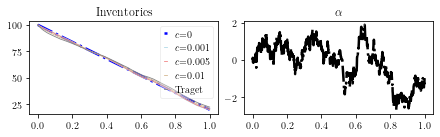

In [22]:
parameter_study_plot(ts, q_target, Trajectories, alpha, '$c$', savefigname='results/transientimpact_different_values.pdf',  W=6)

In [23]:
np.random.seed(14)
Trajectories = {}
for beta_ in (0.1, 1, 2, 5):
    np.random.seed(10)
    print('beta =',beta_)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t      = nb_t, 
                                                                      r_signal  =  10,     sigma_signal     =  5, 
                                                                      c         =  1e-3,  k  =  5e-3,  beta  =  beta_, 
                                                                      phi       =  0.05, 
                                                                      sigma_price = 1, T = 1, 
                                                                      sigma_transient = 0., 
                                                                      q_target  =  q_target, F0=Q0, Q0=Q0, varphi = 1e-1)
    Trajectories[beta_] = Q

beta = 0.1
beta = 1
beta = 2
beta = 5


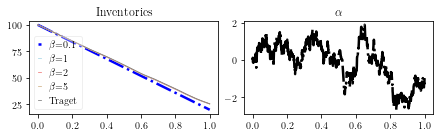

In [24]:
parameter_study_plot(ts, q_target, Trajectories, alpha, r'$\beta$', savefigname='results/transientimpact_beta_different_values.pdf',  W=6)

In [25]:
np.random.seed(14)
Trajectories = {}
for sigma_transient_ in (0, 0.1, 1, 2, 5):
    np.random.seed(10)
    print('sigma transient =', sigma_transient_)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t      = nb_t, 
                                                                      r_signal  =  10,     sigma_signal     =  5, 
                                                                      c         =  1e-3,  k  =  5e-3,  beta  =  5, 
                                                                      phi       =  0.05, 
                                                                      sigma_price = 1, T = 1, 
                                                                      sigma_transient = sigma_transient_, 
                                                                      q_target  =  q_target, F0=Q0, Q0=Q0, varphi = 1e-1)
    Trajectories[sigma_transient_] = Q

sigma transient = 0
sigma transient = 0.1
sigma transient = 1
sigma transient = 2
sigma transient = 5


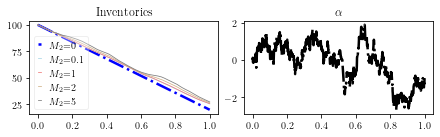

In [26]:
parameter_study_plot(ts, q_target, Trajectories, alpha, '$M_2$', savefigname='results/transientimpact_sigma_different_values.pdf',  W=6)

## Effect of transaction costs

In [ ]:
np.random.seed(14)
Trajectories = {}
for k_ in (1e-4, 1e-3, 1e-2, 5e-2, 5e-1):
    np.random.seed(10)
    print('k =',k_)
    ts, nu, Q, Y, I, alpha, F, g1, g2, g3, g4  = get_strat_simulation(nb_t      = nb_t, 
                                                                      r_signal  =  10,    sigma_signal     =  5, 
                                                                      c         =  1e-3,  k  =  k_,  beta  =  1, 
                                                                      phi       =  0.05,
                                                                      sigma_price = 1, T = 1, 
                                                                      sigma_transient = 0., 
                                                                      q_target  =  q_target, F0=Q0, Q0=Q0, varphi = 1e-1)
    Trajectories[k_] = Q

k = 0.0001
k = 0.001
k = 0.01


In [ ]:
parameter_study_plot(ts, q_target, Trajectories, alpha, '$k$', savefigname='results/k_different_values.pdf',  W=6)